In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

income = pd.read_csv("../Data/income.csv")

income.head()

,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,45,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,28,United-States,"less than or equal to 50,000"
1,24,Federal-gov,HS-grad,Never-married,Armed-Forces,Own-child,White,Male,0,0,40,United-States,"less than or equal to 50,000"
2,44,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,"greater than 50,000"
3,27,Private,9th,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,"less than or equal to 50,000"
4,20,Private,Some-college,Never-married,Sales,Not-in-family,White,Male,0,0,35,United-States,"less than or equal to 50,000"


In [2]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop(["SalStat", "nativecountry", "race"], axis=1), 
        drop_first=True
    )
    X = data.drop("target", axis=1)
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = income_model_prep(income)

## Assignment 1: Simple Ensemble

1. Use the VotingClassifier function to create an ensemble of the three models below.
2. Compare the accuracy of using hard vs. soft scores in this ensemble

In [3]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [4]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.1, penalty="l2", solver="saga", max_iter=1000)

lr = logreg.fit(X_train_std, y_train)

print(f"Train Accuracy: {lr.score(X_train_std, y_train)}")
print(f"Test Accuracy: {lr.score(X_test_std, y_test)}")

Train Accuracy: 0.8507153467281683
Test Accuracy: 0.8555347091932458


In [5]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_std, y_train)

print(f"Train Accuracy: {knn.score(X_train_std, y_train)}")
print(f"Test Accuracy: {knn.score(X_test_std, y_test)}")

c:\Users\Jeffr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Jeffr\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Train Accuracy: 0.8462981784066922
Test Accuracy: 0.8352095059412132


In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=25)

dt.fit(X_train_std, y_train)

print(f"Train Accuracy: {dt.score(X_train_std, y_train)}")
print(f"Test Accuracy: {dt.score(X_test_std, y_test)}")

Train Accuracy: 0.8614650926432648
Test Accuracy: 0.8610068792995622


In [10]:
from sklearn.ensemble import VotingClassifier

hard_model = VotingClassifier(estimators=[
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)],
    voting='hard'
)

hard_model.fit(X_train_std, y_train)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 solver='saga')),
                             ('dt',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=25)),
                             ('knn', KNeighborsClassifier(n_neighbors=25))])

Accuracy: 0.8592870544090057
Precision: 0.7485852869846402
Recall: 0.6112211221122112
F1: 0.6729651162790697


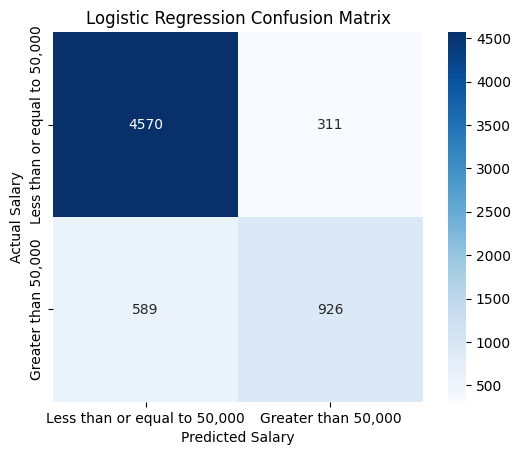

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, hard_model.predict(X_test_std))}")
print(f"Precision: {precision_score(y_test, hard_model.predict(X_test_std))}")
print(f"Recall: {recall_score(y_test, hard_model.predict(X_test_std))}")
print(f"F1: {f1_score(y_test, hard_model.predict(X_test_std))}")

hard_model_confusion = confusion_matrix(y_test, hard_model.predict(X_test_std))
                                 
sns.heatmap(
    hard_model_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["Less than or equal to 50,000", "Greater than 50,000"],        
    yticklabels=["Less than or equal to 50,000", "Greater than 50,000"]
).set(
    xlabel='Predicted Salary',
    ylabel='Actual Salary',
    title='Logistic Regression Confusion Matrix'
);

In [14]:
from sklearn.ensemble import VotingClassifier

soft_model = VotingClassifier(estimators=[
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)],
    voting='soft'
)

soft_model.fit(X_train_std, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 solver='saga')),
                             ('dt',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=25)),
                             ('knn', KNeighborsClassifier(n_neighbors=25))],
                 voting='soft')

Accuracy: 0.8621013133208255
Precision: 0.7661900756938604
Recall: 0.6013201320132013
F1: 0.6738165680473372


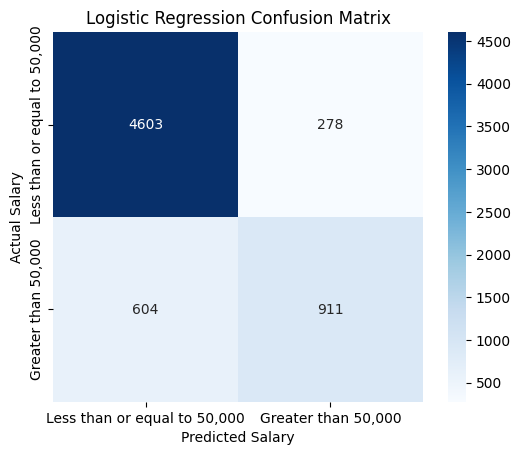

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, soft_model.predict(X_test_std))}")
print(f"Precision: {precision_score(y_test, soft_model.predict(X_test_std))}")
print(f"Recall: {recall_score(y_test, soft_model.predict(X_test_std))}")
print(f"F1: {f1_score(y_test, soft_model.predict(X_test_std))}")

soft_model_confusion = confusion_matrix(y_test, soft_model.predict(X_test_std))
                                 
sns.heatmap(
    soft_model_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["Less than or equal to 50,000", "Greater than 50,000"],        
    yticklabels=["Less than or equal to 50,000", "Greater than 50,000"]
).set(
    xlabel='Predicted Salary',
    ylabel='Actual Salary',
    title='Logistic Regression Confusion Matrix'
);

## Assignment 2: Random Forest

1. Fit a Random Forest model using the default hyperparameters. Only set a random state.
2. Then, perform hyperparameter tuning for your Random Forest.
3. Compare your tuned model's AUC score with your untuned model. 

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=2023, n_jobs=-1)

rf.fit(X_train, y_train)

print(f"Training Accuracy: {rf.score(X_train, y_train)}")
print(f"Test Accuracy: {rf.score(X_test, y_test)}")

Training Accuracy: 0.973653350011727
Test Accuracy: 0.8477173233270794


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
      
rf_rand_tuned = RandomForestClassifier(random_state=2023, n_jobs=-1)

params = {
    'n_estimators': np.arange(start=100, stop=1100, step=100),
    'max_features': [None, "sqrt"],
    'bootstrap': [True, False],
    'max_samples': [None, .3, .5, .9],
    'max_depth': np.arange(start=1, stop=11, step=1),
    'min_samples_leaf': [2, 5, 10, 20, 100],
}

grid = RandomizedSearchCV(
    rf_rand_tuned, 
    params,
    n_iter=100,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np


rf_grid_tuned = RandomForestClassifier(random_state=2023, n_jobs=-1)


params = {
    'n_estimators': np.arange(start=150, stop=250, step=10),
    'bootstrap': [True],
    'max_features': [None, "sqrt"],
    'max_samples': [.8, .9, .95],
    'max_depth': [9],
    'min_samples_leaf': [2, 3, 4]    
}

grid = GridSearchCV(
    rf_grid_tuned, 
    params,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

In [ ]:
rf_tuned = RandomForestClassifier(random_state=2023, n_jobs=-1, **grid.best_params_)

rf_tuned.fit(X_train, y_train)

print(f"Training Accuracy: {rf_tuned.score(X_train, y_train)}")
print(f"Test Accuracy: {rf_tuned.score(X_test, y_test)}")

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
    
# Generate ROC AUC for untuned model
y_probs = rf.predict_proba(X_test)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_probs)
auc_score1 = auc(fpr1, tpr1)

# Generate ROC AUC for tuned model
y_probs = rf_tuned.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_probs)
auc_score2 = auc(fpr2, tpr2)

# Plot the ROC curve
plt.plot(fpr1, tpr1, label=f'Untuned RF (AUC = {auc_score1:.2f})')
plt.plot(fpr2, tpr2, label=f'Tuned RF (AUC = {auc_score2:.2f})')

# Draw Random Guess
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

# Modify Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

## Assignment 3: Gradient Boosting

1. Fit and Tune a GBM
2. Plot Feature Importance for your Tuned GBM - could we remove any features?
2. Plot the tuned GBM ROC curve vs your tuned Random Forest model and report AUC for each